# 带钢表面缺陷分类识别

### 1.导入相关的Python包

In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #训练集，测试集划分函数
import torch
import torch.nn.functional as Fun
from imblearn.over_sampling import SMOTE


### 2.数据预处理

#### 导入数据集

In [2]:
# 屏蔽所有警告信息
warnings.filterwarnings('ignore')
# 以 DataFrame 的形式导入标签文件
labels_pd = pd.read_csv('Faults27x7_var', header=None, prefix="0")
# 提取出标签文件的数据
labels_data = labels_pd.values
# 以 DataFrame的形式导入数据集
dataset = pd.read_table('Faults.tsv', header=None, prefix="0")
# 设置数据集的标签
feature_names = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']
class_names = ['Pastry','Z_Scratch','K_Scratch','Stains','Dirtiness','Bumps','Other_Faults']
columns = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
dataset.columns = columns
# 查看数据集
dataset

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


#### 查看数据基本信息

In [3]:
# 查看数据集大小
dataset.shape

(1941, 34)

#### 查看数据集是否有缺失值和离散值

In [4]:
# 查看数据集是否有缺失值
dataset.shape[0] - dataset.count(0)

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

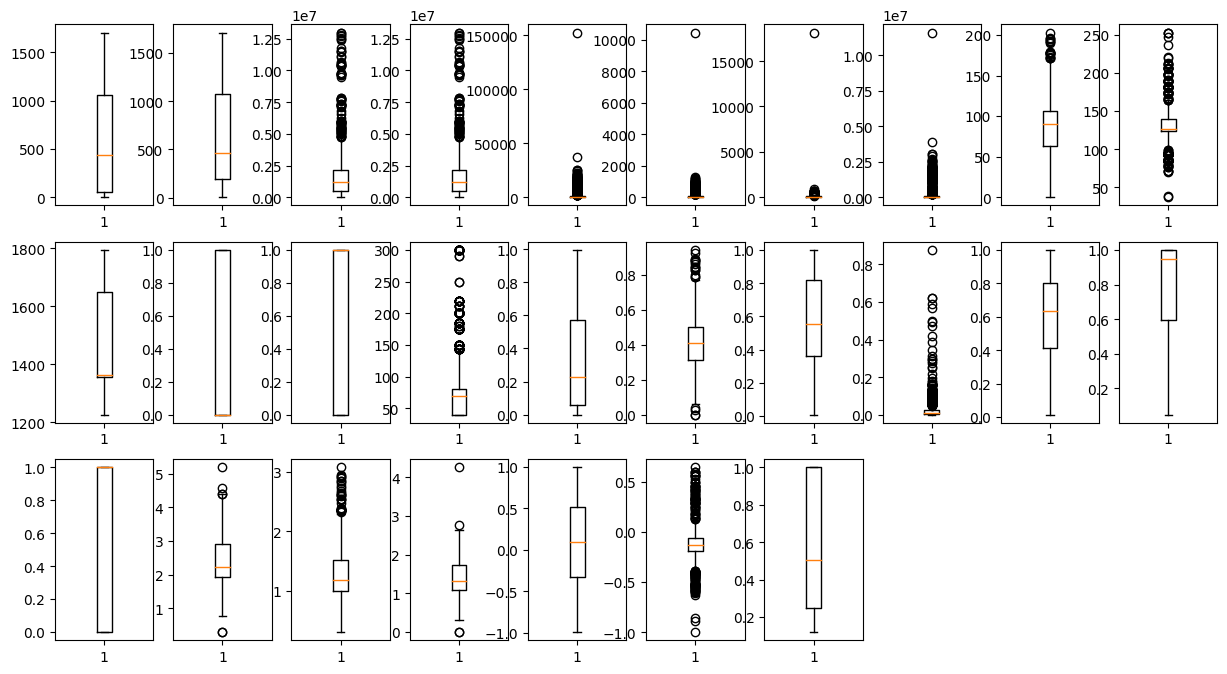

In [5]:
# 查看数据集是否有离散值
# 1.箱型图法
plt.figure(figsize=(15, 8))
for i in range(1, 28, 1):
    plt.subplot(3, 10, i)
    plt.boxplot(dataset[dataset.columns[i - 1]])

In [6]:
# 2.局部离群值因子法(LOF)
clf = LocalOutlierFactor(n_neighbors=20)  # 近邻数是超参数，20为默认值，一般取该值效果不错
dataset_LOF_copy = dataset[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']].copy()
y_pred = clf.fit_predict(np.array(dataset_LOF_copy))  # 结果中-1表离群样本，1表正常样本
LOF_arr = dataset[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']][y_pred==-1]
LOF_arr

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
4,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0
9,1,0,0,0,0,0,0
12,1,0,0,0,0,0,0
14,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1749,0,0,0,0,0,0,1
1763,0,0,0,0,0,0,1
1863,0,0,0,0,0,0,1
1891,0,0,0,0,0,0,1


#### 将输入特征与输出特征分开

In [7]:
X = dataset[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']]
# 将dataset数据集转为二维数组
dataset_data = dataset.values
# 将原数据集的Y化简到1维，Pastry为1，Z_Scratch为2，以此类推直到7
Y_data = []
for i in range(len(dataset_data)):
    for j in range(27, 34, 1):
        if (dataset_data[i][j] == 1):
           Y_data.append(j - 27 + 1)
# 将Y的数据转为英文，便于分析
for i in range(len(Y_data)):
    if (Y_data[i] == 1):
        Y_data[i] = 'Pastry'
    elif (Y_data[i] == 2):
        Y_data[i] = 'Z_Scratch'
    elif (Y_data[i] == 3):
        Y_data[i] = 'K_Scratch'
    elif (Y_data[i] == 4):
        Y_data[i] = 'Stains'
    elif (Y_data[i] == 5):
        Y_data[i] = 'Dirtiness'
    elif (Y_data[i] == 6):
        Y_data[i] = 'Bumps'
    elif (Y_data[i] == 7):
        Y_data[i] = 'Other_Faults'
# 输出集
Y = pd.DataFrame(Y_data)
Y.columns = ['category']
Y.value_counts()

category    
Other_Faults    673
Bumps           402
K_Scratch       391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64

#### 对输入数据做标准化

In [8]:
X = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(X)
X.columns = feature_names

#### 构造模型评价函数

In [9]:
def showCVResults(cv_results):
    print('fit_time:%.4f' % cv_results['fit_time'].mean())
    print('score_time:%.4f' % cv_results['score_time'].mean())
    print('accuracy:%.4f' % cv_results['test_accuracy'].mean())
    print('precision_weighted:%.4f' % cv_results['test_precision_weighted'].mean())
    print('recall_weighted:%.4f' % cv_results['test_recall_weighted'].mean())
    print('f1_weighted:%.4f' % cv_results['test_f1_weighted'].mean())
    print('precision_macro:%.4f' % cv_results['test_precision_macro'].mean())
    print('recall_macro:%.4f' % cv_results['test_recall_macro'].mean())
    print('f1_macro:%.4f' % cv_results['test_f1_macro'].mean())

#### 构造分层的交叉验证迭代器并分离训练集和测试集

In [27]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
# 分层划分训练集和测试集，使训练集、测试集中各类别样本数量比例与原始数据集保持一致
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=3, stratify=Y)
# test_size:  若为小数，则为测试集样本占总样本的比例；若为整数，则为测试集样本数量
# random_state：随机数的种子，在需要重复试验的时候，指定一个固定值，则得到相同的划分结果
# stratify：划分前是否打乱原始样本顺序
y_train.value_counts()  # 训练集中各类样本数量统计


category    
Other_Faults    605
Bumps           362
K_Scratch       352
Z_Scratch       171
Pastry          142
Stains           65
Dirtiness        49
dtype: int64

In [28]:
# 测试集中各类样本数量统计
y_test.value_counts()

category    
Other_Faults    68
Bumps           40
K_Scratch       39
Z_Scratch       19
Pastry          16
Stains           7
Dirtiness        6
dtype: int64

In [14]:
sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts()

category    
Bumps           605
Dirtiness       605
K_Scratch       605
Other_Faults    605
Pastry          605
Stains          605
Z_Scratch       605
dtype: int64

### 3.使用决策树进行分类

In [29]:
# 不做任何剪枝操作的决策树拟合
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(classification_report(y_pred, y_test))
# # 执行交叉验证并进行多指标评估
# cv_results_dt = cross_validate(estimator=dtc, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
# showCVResults(cv_results_dt)

              precision    recall  f1-score   support

       Bumps       0.55      0.54      0.54        41
   Dirtiness       0.83      0.62      0.71         8
   K_Scratch       0.95      0.95      0.95        39
Other_Faults       0.57      0.61      0.59        64
      Pastry       0.56      0.47      0.51        19
      Stains       1.00      0.88      0.93         8
   Z_Scratch       0.68      0.81      0.74        16

    accuracy                           0.68       195
   macro avg       0.74      0.70      0.71       195
weighted avg       0.68      0.68      0.68       195



In [20]:
# 将决策树进行完整的可视化
dtc.fit(X_train, y_train)
export_graphviz(dtc, out_file="D://tree.dot",
                feature_names=feature_names, class_names=class_names,
                filled=True, rounded=True,special_characters=True)

[0.         0.00018814 0.0002024  0.00020661 0.00020661 0.00022039
 0.00022137 0.00022586 0.00022629 0.00022668 0.00022826 0.00022897
 0.00022957 0.00023064 0.00023232 0.00023502 0.00023613 0.00023613
 0.00023613 0.00023613 0.00023613 0.00023613 0.00023613 0.00023613
 0.00023613 0.00023613 0.00023613 0.00023613 0.00023613 0.00023613
 0.00023613 0.00023613 0.00023613 0.00023613 0.00023613 0.00023613
 0.00023613 0.00028335 0.00031484 0.00031484 0.00031484 0.00031484
 0.00031484 0.00031484 0.00031484 0.00031484 0.00031484 0.00033058
 0.00033555 0.00034927 0.00035352 0.00035419 0.00035419 0.00035419
 0.00035419 0.00035419 0.00035419 0.00035419 0.00035419 0.00035419
 0.00035419 0.00035419 0.00035419 0.00035981 0.00037387 0.0003778
 0.0003778  0.0003778  0.0003778  0.0003778  0.0003778  0.00039355
 0.00039355 0.00039355 0.00039355 0.00039355 0.00040299 0.00040479
 0.00040479 0.00040479 0.00040479 0.00041322 0.00041322 0.00041322
 0.0004167  0.00041776 0.00042254 0.00042503 0.00042503 0.00042

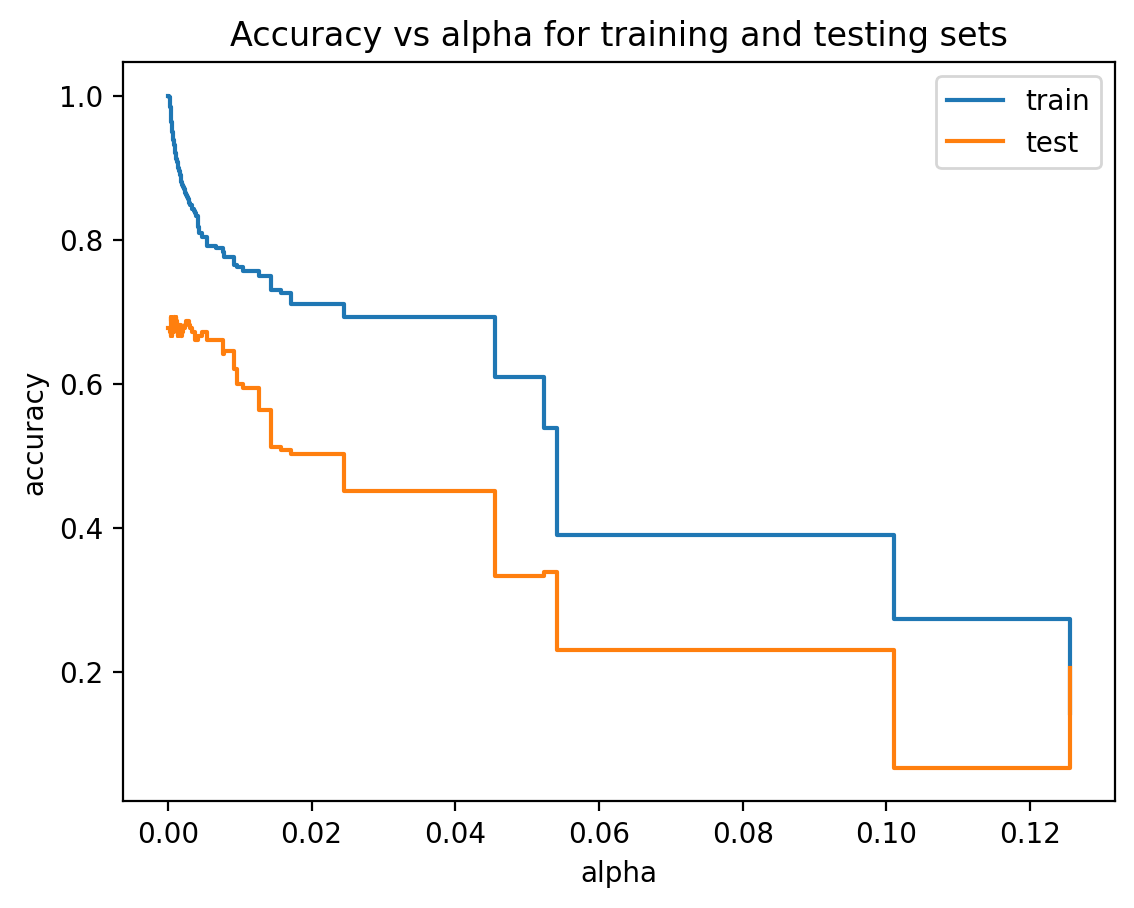

In [21]:
# 对决策树进行预剪枝和后剪枝
# 后剪枝
path = dtc.cost_complexity_pruning_path(X_train, y_train)
#cost_complexity_pruning_path：返回两个参数，
#第一个是CCP剪枝后决策树序列T0,T1,...,Tt对应的误差率增益率α；第二个是剪枝后决策树所有叶子节点的不纯度
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
# ccp_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
#输出最后一个数的节点个数和ccp_alphas
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
plt.rcParams['savefig.dpi'] = 80 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
# 默认的像素：[6.0,4.0]，分辨率为100，图片尺寸为 600*400
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='', label="test",
        drawstyle="steps-post")
ax.legend()

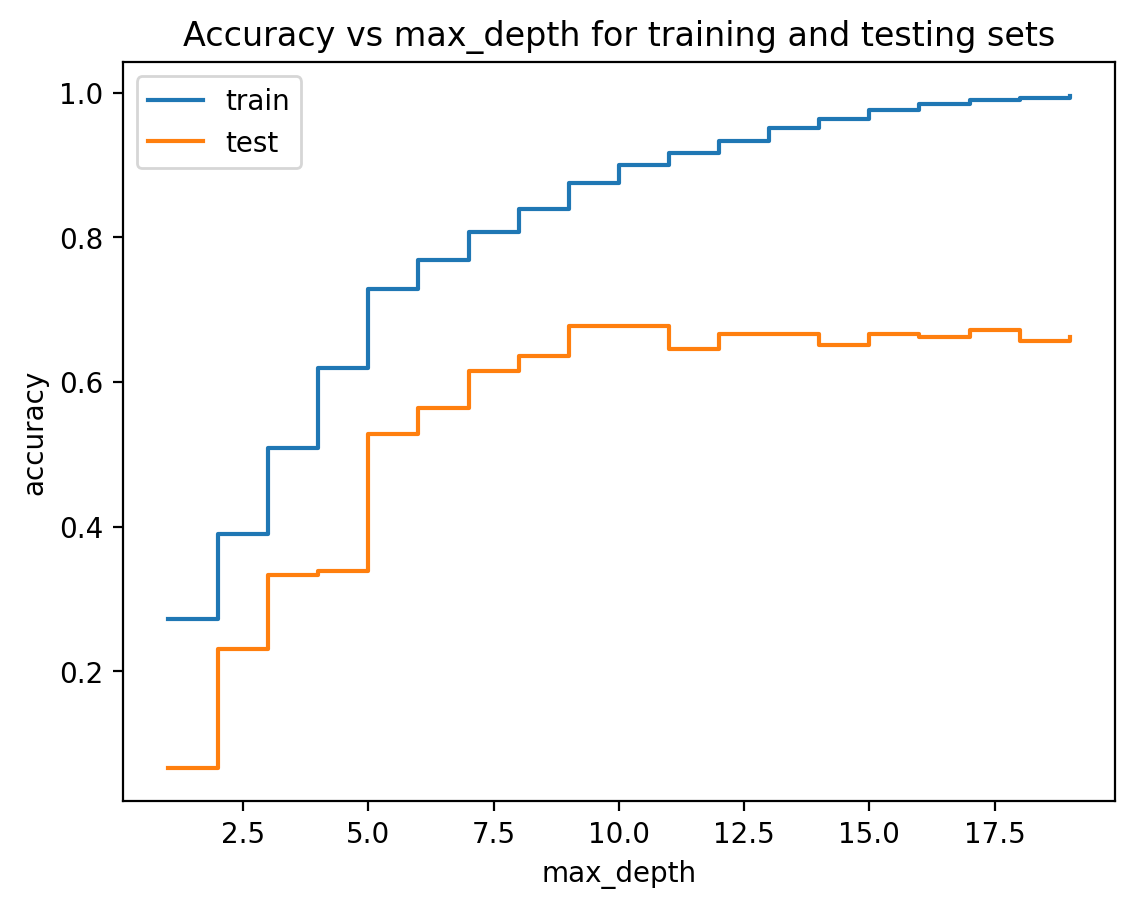

In [22]:
# 预剪枝
max_depth = np.arange(1, 20, 1)
dtcs = []
for i in max_depth:
    dtc = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=i)
    dtc.fit(X_train, y_train)
    dtcs.append(dtc)
train_scores = [dtc.score(X_train, y_train) for dtc in dtcs]
test_scores = [dtc.score(X_test, y_test) for dtc in dtcs]
plt.rcParams['savefig.dpi'] = 80 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
# 默认的像素：[6.0,4.0]，分辨率为100，图片尺寸为 600*400
fig, ax = plt.subplots()
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs max_depth for training and testing sets")
ax.plot(max_depth, train_scores, marker='', label="train",
        drawstyle="steps-post")
ax.plot(max_depth, test_scores, marker='', label="test",
        drawstyle="steps-post")
ax.legend()

In [23]:
# 使用网格搜索法寻求最优参数
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
param_grid = [
    {
        'max_depth': np.arange(1, 20, 1),
        'ccp_alpha': [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
    }
]
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)
# 最佳模型得分
print(grid_search.best_score_)

# 最佳的模型参数
print(grid_search.best_params_)

0.7372508591065292
{'ccp_alpha': 0, 'max_depth': 15}


In [24]:
dtc = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=17, ccp_alpha=0)
# 执行交叉验证并进行多指标评估
cv_results_dt = cross_validate(estimator=dtc, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_dt)

fit_time:0.0408
score_time:0.0099
accuracy:0.7275
precision_weighted:0.7284
recall_weighted:0.7275
f1_weighted:0.7255
precision_macro:0.7458
recall_macro:0.7623
f1_macro:0.7494


In [25]:
# 将决策树进行完整的可视化
dtc.fit(X_train, y_train)
export_graphviz(dtc, out_file="D://tree.dot",
                feature_names=feature_names,class_names=class_names,
                filled=True, rounded=True,special_characters=True)

### 4.支持向量机

In [26]:
model_svm = SVC(kernel='rbf', gamma=0.1, C=1)
model_svm.fit(X_train, y_train)
cv_results_lr = cross_validate(estimator=model_svm, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_lr)

fit_time:0.1530
score_time:0.0398
accuracy:0.7707
precision_weighted:0.7759
recall_weighted:0.7707
f1_weighted:0.7690
precision_macro:0.8098
recall_macro:0.7666
f1_macro:0.7812


In [ ]:
param_grid = [
    {
        'C': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
              1.9, 2.0],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }
]
grid_search = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)
# 最佳模型得分
print(grid_search.best_score_)
# 最佳的模型参数
print(grid_search.best_params_)

In [ ]:

import pandas as pd
import numpy as np
import numpy.linalg as la
import random


# 异常类
class ReliefError:
    pass


class Relief:
    def __init__(self, data_df, sample_rate, t, k):
        """
        #
        :param data_df: 数据框（字段为特征，行为样本）
        :param sample_rate: 抽样比例
        :param t: 统计量分量阈值
        :param k: k近邻的个数
        """
        self.__data = data_df
        self.__feature = data_df.columns
        self.__sample_num = int(round(len(data_df) * sample_rate))
        self.__t = t
        self.__k = k

    # 数据处理（将离散型数据处理成连续型数据，比如字符到数值）
    def get_data(self):
        new_data = pd.DataFrame()
        for one in self.__feature[:-1]:
            col = self.__data[one]
            if (str(list(col)[0]).split(".")[0]).isdigit() or str(list(col)[0]).isdigit() or (str(list(col)[0]).split('-')[-1]).split(".")[-1].isdigit():
                new_data[one] = self.__data[one]
                # print '%s 是数值型' % one
            else:
                # print '%s 是离散型' % one
                keys = list(set(list(col)))
                values = list(xrange(len(keys)))
                new = dict(zip(keys, values))
                new_data[one] = self.__data[one].map(new)
        new_data[self.__feature[-1]] = self.__data[self.__feature[-1]]
        return new_data

    # 返回一个样本的k个猜中近邻和其他类的k个猜错近邻
    def get_neighbors(self, row):
        df = self.get_data()
        row_type = row[df.columns[-1]]
        right_df = df[df[df.columns[-1]] == row_type].drop(columns=[df.columns[-1]])
        aim = row.drop(df.columns[-1])
        f = lambda x: eulidSim(np.mat(x.values), np.mat(aim.values))
        right_sim = right_df.apply(f, axis=1)
        right_sim_two = right_sim.drop(right_sim.idxmin())
        right = dict()
        right[row_type] = list(right_sim_two.sort_values().index[0:self.__k])
        # print list(right_sim_two.sort_values().index[0:self.__k])
        types = list(set(df[df.columns[-1]]) - set([row_type]))
        wrong = dict()
        for one in types:
            wrong_df = df[df[df.columns[-1]] == one].drop(columns=[df.columns[-1]])
            wrong_sim = wrong_df.apply(f, axis=1)
            wrong[one] = list(wrong_sim.sort_values().index[0:self.__k])
        print( right, wrong)
        return right, wrong

    # 计算特征权重
    def get_weight(self, feature, index, NearHit, NearMiss):
        # data = self.__data.drop(self.__feature[-1], axis=1)
        data = self.__data
        row = data.iloc[index]
        right = 0
        for one in list(NearHit.values())[0]:
            nearhit = data.iloc[one]
            if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                max_feature = data[feature].max()
                min_feature = data[feature].min()
                right_one = pow(round(abs(row[feature] - nearhit[feature]) / (max_feature - min_feature), 2), 2)
            else:
                right_one = 0 if row[feature] == nearhit[feature] else 1
            right += right_one
        right_w = round(right / self.__k, 2)

        wrong_w = 0
        # 样本row所在的种类占样本集的比例
        p_row = round(float(list(data[data.columns[-1]]).count(row[data.columns[-1]])) / len(data), 2)
        for one in NearMiss.keys():
            # 种类one在样本集中所占的比例
            p_one = round(float(list(data[data.columns[-1]]).count(one)) / len(data), 2)
            wrong_one = 0
            for i in NearMiss[one]:
                nearmiss = data.iloc[i]
                if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                    max_feature = data[feature].max()
                    min_feature = data[feature].min()
                    wrong_one_one = pow(round(abs(row[feature] - nearmiss[feature]) / (max_feature - min_feature), 2), 2)
                else:
                    wrong_one_one = 0 if row[feature] == nearmiss[feature] else 1
                wrong_one += wrong_one_one

            wrong = round(p_one / (1 - p_row) * wrong_one / self.__k, 2)
            wrong_w += wrong
        w = wrong_w - right_w
        return w

    # 过滤式特征选择
    def reliefF(self):
        sample = self.get_data()
        # print sample
        m, n = np.shape(self.__data)  # m为行数，n为列数
        score = []
        sample_index = random.sample(range(0, m), self.__sample_num)
        print ('采样样本索引为 %s ' % sample_index)
        num = 1
        for i in sample_index:    # 采样次数
            one_score = dict()
            row = sample.iloc[i]
            NearHit, NearMiss = self.get_neighbors(row)
            print( '第 %s 次采样，样本index为 %s，其NearHit k近邻行索引为 %s ，NearMiss k近邻行索引为 %s' % (num, i, NearHit, NearMiss))
            for f in self.__feature[0:-1]:
                w = self.get_weight(f, i, NearHit, NearMiss)
                one_score[f] = w
                print ('特征 %s 的权重为 %s.' % (f, w))
            score.append(one_score)
            num += 1
        f_w = pd.DataFrame(score)
        print( '采样各样本特征权重如下：')
        print (f_w)
        print( '平均特征权重如下：')
        print (f_w.mean())
        return f_w.mean()

    # 返回最终选取的特征
    def get_final(self):
        f_w = pd.DataFrame(self.reliefF(), columns=['weight'])
        final_feature_t = f_w[f_w['weight'] > self.__t]
        print( final_feature_t)
        # final_feature_k = f_w.sort_values('weight').head(self.__k)
        # print final_feature_k
        return final_feature_t


# 几种距离求解
def eulidSim(vecA, vecB):
    return la.norm(vecA - vecB)


def cosSim(vecA, vecB):
    """
    :param vecA: 行向量
    :param vecB: 行向量
    :return: 返回余弦相似度（范围在0-1之间）
    """
    num = float(vecA * vecB.T)
    denom = la.norm(vecA) * la.norm(vecB)
    cosSim = 0.5 + 0.5 * (num / denom)
    return cosSim


def pearsSim(vecA, vecB):
    if len(vecA) < 3:
        return 1.0
    else:
        return 0.5 + 0.5 * np.corrcoef(vecA, vecB, rowvar=0)[0][1]


if __name__ == '__main__':
    data = X
    #data = np.ndarray.tolist(data)
    print (data)
    f = Relief(data, 1, 0.2, 2)
    # df = f.get_data()
    # print type(df.iloc[0])
    # f.get_neighbors(df.iloc[0])
    # f.get_weight('色泽', 6, 7, 8)
    f.reliefF()
    # f.get_final()
    

In [ ]:

import pandas as pd
import numpy as np
import numpy.linalg as la
import random


# 异常类
class ReliefError:
    pass


class Relief:
    def __init__(self, data_df, sample_rate, t, k):
        """
        #
        :param data_df: 数据框（字段为特征，行为样本）
        :param sample_rate: 抽样比例
        :param t: 统计量分量阈值
        :param k: k近邻的个数
        """
        self.__data = data_df
        self.__feature = data_df.columns
        self.__sample_num = int(round(len(data_df) * sample_rate))
        self.__t = t
        self.__k = k

    # 数据处理（将离散型数据处理成连续型数据，比如字符到数值）
    def get_data(self):
        new_data = pd.DataFrame()
        for one in self.__feature[:-1]:
            col = self.__data[one]
            if (str(list(col)[0]).split(".")[0]).isdigit() or str(list(col)[0]).isdigit() or (str(list(col)[0]).split('-')[-1]).split(".")[-1].isdigit():
                new_data[one] = self.__data[one]
                # print '%s 是数值型' % one
            else:
                # print '%s 是离散型' % one
                keys = list(set(list(col)))
                values = list(xrange(len(keys)))
                new = dict(zip(keys, values))
                new_data[one] = self.__data[one].map(new)
        new_data[self.__feature[-1]] = self.__data[self.__feature[-1]]
        return new_data

    # 返回一个样本的k个猜中近邻和其他类的k个猜错近邻
    def get_neighbors(self, row):
        df = self.get_data()
        row_type = row[df.columns[-1]]
        right_df = df[df[df.columns[-1]] == row_type].drop(columns=[df.columns[-1]])
        aim = row.drop(df.columns[-1])
        f = lambda x: eulidSim(np.mat(x.values), np.mat(aim.values))
        right_sim = right_df.apply(f, axis=1)
        right_sim_two = right_sim.drop(right_sim.idxmin())
        right = dict()
        right[row_type] = list(right_sim_two.sort_values().index[0:self.__k])
        # print list(right_sim_two.sort_values().index[0:self.__k])
        types = list(set(df[df.columns[-1]]) - set([row_type]))
        wrong = dict()
        for one in types:
            wrong_df = df[df[df.columns[-1]] == one].drop(columns=[df.columns[-1]])
            wrong_sim = wrong_df.apply(f, axis=1)
            wrong[one] = list(wrong_sim.sort_values().index[0:self.__k])
        print( right, wrong)
        return right, wrong

    # 计算特征权重
    def get_weight(self, feature, index, NearHit, NearMiss):
        # data = self.__data.drop(self.__feature[-1], axis=1)
        data = self.__data
        row = data.iloc[index]
        right = 0
        for one in list(NearHit.values())[0]:
            nearhit = data.iloc[one]
            if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                max_feature = data[feature].max()
                min_feature = data[feature].min()
                right_one = pow(round(abs(row[feature] - nearhit[feature]) / (max_feature - min_feature), 2), 2)
            else:
                right_one = 0 if row[feature] == nearhit[feature] else 1
            right += right_one
        right_w = round(right / self.__k, 2)

        wrong_w = 0
        # 样本row所在的种类占样本集的比例
        p_row = round(float(list(data[data.columns[-1]]).count(row[data.columns[-1]])) / len(data), 2)
        for one in NearMiss.keys():
            # 种类one在样本集中所占的比例
            p_one = round(float(list(data[data.columns[-1]]).count(one)) / len(data), 2)
            wrong_one = 0
            for i in NearMiss[one]:
                nearmiss = data.iloc[i]
                if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                    max_feature = data[feature].max()
                    min_feature = data[feature].min()
                    wrong_one_one = pow(round(abs(row[feature] - nearmiss[feature]) / (max_feature - min_feature), 2), 2)
                else:
                    wrong_one_one = 0 if row[feature] == nearmiss[feature] else 1
                wrong_one += wrong_one_one

            wrong = round(p_one / (1 - p_row) * wrong_one / self.__k, 2)
            wrong_w += wrong
        w = wrong_w - right_w
        return w

    # 过滤式特征选择
    def reliefF(self):
        sample = self.get_data()
        # print sample
        m, n = np.shape(self.__data)  # m为行数，n为列数
        score = []
        sample_index = random.sample(range(0, m), self.__sample_num)
        print ('采样样本索引为 %s ' % sample_index)
        num = 1
        for i in sample_index:    # 采样次数
            one_score = dict()
            row = sample.iloc[i]
            NearHit, NearMiss = self.get_neighbors(row)
            print( '第 %s 次采样，样本index为 %s，其NearHit k近邻行索引为 %s ，NearMiss k近邻行索引为 %s' % (num, i, NearHit, NearMiss))
            for f in self.__feature[0:-1]:
                w = self.get_weight(f, i, NearHit, NearMiss)
                one_score[f] = w
                print ('特征 %s 的权重为 %s.' % (f, w))
            score.append(one_score)
            num += 1
        f_w = pd.DataFrame(score)
        print( '采样各样本特征权重如下：')
        print (f_w)
        print( '平均特征权重如下：')
        print (f_w.mean())
        return f_w.mean()

    # 返回最终选取的特征
    def get_final(self):
        f_w = pd.DataFrame(self.reliefF(), columns=['weight'])
        final_feature_t = f_w[f_w['weight'] > self.__t]
        print( final_feature_t)
        # final_feature_k = f_w.sort_values('weight').head(self.__k)
        # print final_feature_k
        return final_feature_t


# 几种距离求解
def eulidSim(vecA, vecB):
    return la.norm(vecA - vecB)


def cosSim(vecA, vecB):
    """
    :param vecA: 行向量
    :param vecB: 行向量
    :return: 返回余弦相似度（范围在0-1之间）
    """
    num = float(vecA * vecB.T)
    denom = la.norm(vecA) * la.norm(vecB)
    cosSim = 0.5 + 0.5 * (num / denom)
    return cosSim


def pearsSim(vecA, vecB):
    if len(vecA) < 3:
        return 1.0
    else:
        return 0.5 + 0.5 * np.corrcoef(vecA, vecB, rowvar=0)[0][1]


if __name__ == '__main__':
    data = X
    #data = np.ndarray.tolist(data)
    print (data)
    f = Relief(data, 1, 0.2, 2)
    # df = f.get_data()
    # print type(df.iloc[0])
    # f.get_neighbors(df.iloc[0])
    # f.get_weight('色泽', 6, 7, 8)
    f.reliefF()
    # f.get_final()
    

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0     -1.016481  -1.141639  -0.777729  -0.777729     -0.314852    -0.314996   
1      0.141894   0.066403   0.500188   0.500171     -0.345623    -0.338242   
2      0.495362   0.436253  -0.054546  -0.054566     -0.352784    -0.344883   
3      0.541467   0.486504  -0.722225  -0.722225     -0.332463    -0.328279   
4      1.379032   1.382988  -0.649678  -0.649559      0.099692    -0.172201   
...         ...        ...        ...        ...           ...          ...   
1936  -0.618830  -0.685357  -0.746795  -0.746811     -0.313690    -0.192126   
1937  -0.820537  -0.890382  -0.738452  -0.738468     -0.310981    -0.225334   
1938  -0.818616  -0.892392  -0.712412  -0.712430     -0.310013    -0.238617   
1939  -0.833984  -0.900432  -0.692280  -0.692288     -0.285435    -0.049331   
1940   1.325243   1.332737  -0.880850  -0.880865     -0.346591    -0.285109   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Lu

{-1.2980752140546237: [781, 783]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142], -0.7175781787641053: [1910, 1124], -0.5295796465228104: [820], 1.0566211356948854: [51], -0.8622604347679858: [295, 1032], 0.06624015315101107: [1744, 294], 0.8821773565618973: [567], 0.853005170524455: [1740, 1008], 1.1965886949654423: [817], -0.26761930927749533: [1506, 1809], -1.015488078601016: [1107, 271], -1.2196933808631123: [770, 376], -0.8210068383514006: [1917, 1188], 1.2110274537112466: [848], 0.16731146437164449: [1429, 1109], 0.09865369319261366: [998], -1.1239261034674684: [1789, 1024], 0.731307061095529: [1178], 0.7734446631496124: [1672], 1.0392356914907535: [37], 1.071649231532356: [533, 104], 1.1494417276322022: [1598, 812], 1.2142688077154074: [1359], 1.0781319395406765: [1462], -1.2084959761214678: [1647, 3

特征 X_Minimum 的权重为 0.0.
特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.02.
特征 TypeOfSteel_A400 的权重为 0.02.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.14.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.04.
特征 Log_X_Index 的权重为 0.03.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [1684, 1685]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 13], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1693, 195], 1.087856001553157: [1142], -

特征 X_Minimum 的权重为 0.0.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.20000000000000004.
特征 TypeOfSteel_A400 的权重为 0.20000000000000004.
特征 Steel_Plate_Thickness 的权重为 0.01.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 -0.05.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 -0.03.
特征 Outside_Global_Index 的权重为 0.060000000000000005.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [1521, 1289]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 0.05.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.019999999999999997.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.05.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 -0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [658, 657]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.0

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.2700000000000001.
特征 TypeOfSteel_A400 的权重为 0.2700000000000001.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{0.7981968209995632: [289]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1126, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.71757817

特征 X_Maximum 的权重为 -0.020000000000000004.
特征 Y_Minimum 的权重为 -0.03.
特征 Y_Maximum 的权重为 -0.03.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.03.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.09.
特征 Edges_Index 的权重为 -0.18.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.03.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [214, 222]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.

特征 X_Minimum 的权重为 0.01.
特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.05.
特征 TypeOfSteel_A400 的权重为 0.05.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.010000000000000002.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.060000000000000005.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.060000000000000005.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.11586500817362866: [1888, 1332]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.220751

特征 X_Maximum 的权重为 -0.18.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.04.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.16.
特征 TypeOfSteel_A300 的权重为 -0.49.
特征 TypeOfSteel_A400 的权重为 -0.49.
特征 Steel_Plate_Thickness 的权重为 -0.06.
特征 Edges_Index 的权重为 -0.049999999999999996.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 -0.1.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.2.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.0.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.03.
特征 Luminosity_Index 的权重为 -0.02.
{0.5318164555667569: [1645, 133]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [

特征 X_Maximum 的权重为 -0.49.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.21.
特征 TypeOfSteel_A300 的权重为 0.19000000000000003.
特征 TypeOfSteel_A400 的权重为 0.19000000000000003.
特征 Steel_Plate_Thickness 的权重为 -0.02.
特征 Edges_Index 的权重为 -0.44.
特征 Empty_Index 的权重为 -0.019999999999999997.
特征 Square_Index 的权重为 -0.010000000000000002.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.06.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 -0.01.
{0.12193250831340101: [1781, 1919]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207

特征 X_Minimum 的权重为 -0.21.
特征 X_Maximum 的权重为 -0.21.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.09000000000000001.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.09.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.08.
特征 Edges_Y_Index 的权重为 0.009999999999999998.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.02.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [423, 422]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515

特征 X_Minimum 的权重为 0.01.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.19000000000000003.
特征 TypeOfSteel_A400 的权重为 0.19000000000000003.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.03.
特征 Edges_Y_Index 的权重为 0.16.
特征 Outside_Global_Index 的权重为 0.18000000000000002.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [521, 515]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1

特征 X_Minimum 的权重为 0.01.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.0045853424052043: [1760, 1855]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [2

特征 X_Maximum 的权重为 -0.22.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.03.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.18.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.53.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 -0.03.
{1.221635521361226: [441, 407]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142], -0.717578178

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.9023353570012399: [66, 1473]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.0878

特征 X_Minimum 的权重为 -0.16.
特征 X_Maximum 的权重为 -0.16.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.14.
特征 TypeOfSteel_A300 的权重为 -0.47.
特征 TypeOfSteel_A400 的权重为 -0.47.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.47.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 -0.019999999999999997.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.13.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.0.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 -0.02.
{-0.782994595938976: [157, 1192]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 13], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 1

特征 X_Maximum 的权重为 -0.26.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.37.
特征 TypeOfSteel_A300 的权重为 -0.45.
特征 TypeOfSteel_A400 的权重为 -0.45.
特征 Steel_Plate_Thickness 的权重为 -0.32.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.019999999999999997.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.0.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-0.9936826062093926: [1190, 81]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1126, 40], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001553157: [1142], 

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 0.0.
特征 TypeOfSteel_A400 的权重为 0.0.
特征 Steel_Plate_Thickness 的权重为 -0.25.
特征 Edges_Index 的权重为 -0.11.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.009999999999999998.
特征 Edges_Y_Index 的权重为 0.01.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [669, 672]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.717

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.05.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [736, 734]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553

特征 X_Minimum 的权重为 0.0.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.18000000000000002.
特征 TypeOfSteel_A400 的权重为 0.18000000000000002.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 -0.39.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [952, 953]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001

特征 X_Maximum 的权重为 -0.02.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.09.
特征 TypeOfSteel_A400 的权重为 0.09.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.06.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 -0.11.
特征 Outside_Global_Index 的权重为 0.02.
特征 LogOfAreas 的权重为 -0.03.
特征 Log_X_Index 的权重为 -0.03.
特征 Log_Y_Index 的权重为 -0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.1551609693257399: [1468, 1882]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142], -0.71757817876

特征 X_Maximum 的权重为 -0.02.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.04.
特征 Maximum_of_Luminosity 的权重为 -0.039999999999999994.
特征 Length_of_Conveyer 的权重为 -0.13.
特征 TypeOfSteel_A300 的权重为 -0.29999999999999993.
特征 TypeOfSteel_A400 的权重为 -0.29999999999999993.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.13999999999999999.
特征 Empty_Index 的权重为 -0.020000000000000004.
特征 Square_Index 的权重为 -0.39.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.019999999999999997.
特征 Edges_Y_Index 的权重为 -0.21.
特征 Outside_Global_Index 的权重为 0.16.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 -0.05.
特征 Log_Y_Index 的权重为 -0.01.
特征 Orientation_Index 的权重为 -0.12.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [1708, 1707]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 1126], 1.1974727006029404: [17], 1.1305829406989059:

特征 X_Maximum 的权重为 0.02.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.16.
特征 TypeOfSteel_A400 的权重为 0.16.
特征 Steel_Plate_Thickness 的权重为 0.04.
特征 Edges_Index 的权重为 0.01.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.04.
特征 Edges_Y_Index 的权重为 -0.04.
特征 Outside_Global_Index 的权重为 0.09.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [522, 507]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.7175781787641053: [304,

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.23000000000000007.
特征 TypeOfSteel_A400 的权重为 0.23000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.060000000000000005.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.9936826062093926: [1105, 81]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 0.0.
特征 TypeOfSteel_A400 的权重为 0.0.
特征 Steel_Plate_Thickness 的权重为 -0.13.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 -0.05.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.030000000000000002.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [578, 563]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.7175

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.13999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{0.812635579745368: [1099, 10]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: 

特征 X_Maximum 的权重为 -0.36.
特征 Y_Minimum 的权重为 -0.03.
特征 Y_Maximum 的权重为 -0.03.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.08.
特征 TypeOfSteel_A300 的权重为 -0.99.
特征 TypeOfSteel_A400 的权重为 -0.99.
特征 Steel_Plate_Thickness 的权重为 -0.05.
特征 Edges_Index 的权重为 -0.14.
特征 Empty_Index 的权重为 -0.07.
特征 Square_Index 的权重为 -0.16999999999999998.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.16.
特征 Edges_Y_Index 的权重为 -0.03.
特征 Outside_Global_Index 的权重为 -0.12.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.04.
特征 Luminosity_Index 的权重为 -0.01.
{-1.029926837346821: [1875, 989]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 128], 1.08785600155315

特征 X_Maximum 的权重为 -0.09000000000000001.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 -0.060000000000000005.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.09.
特征 TypeOfSteel_A400 的权重为 0.09.
特征 Steel_Plate_Thickness 的权重为 0.01.
特征 Edges_Index 的权重为 -0.33.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 -0.07000000000000002.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.08.
特征 Edges_Y_Index 的权重为 -0.19999999999999998.
特征 Outside_Global_Index 的权重为 -0.42.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 -0.019999999999999997.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.19999999999999998.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [501, 515]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.05.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.0084160335010302: [1144, 1860]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.08785600155

特征 X_Maximum 的权重为 0.03.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.03.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.01.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.1.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 -0.42.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.01.
{-1.120684749463308: [981, 240]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 1657], 1.087856001553157: [1142], -0.717578178764

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 -0.42.
特征 TypeOfSteel_A400 的权重为 -0.42.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.03.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.5531531301894306: [772, 178]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142], -0.

特征 X_Maximum 的权重为 -0.03.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.04.
特征 TypeOfSteel_A300 的权重为 -0.2899999999999999.
特征 TypeOfSteel_A400 的权重为 -0.2899999999999999.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.15.
特征 Empty_Index 的权重为 -0.04.
特征 Square_Index 的权重为 -0.17.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.08.
特征 Edges_Y_Index 的权重为 -0.21.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.05.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [558, 559]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 2

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.13999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.9639210830802848: [1011, 1173]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [247, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.0878560015

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.09.
特征 TypeOfSteel_A300 的权重为 0.03.
特征 TypeOfSteel_A400 的权重为 0.03.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 0.02.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [503, 496]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.04.
特征 Edges_Y_Index 的权重为 0.09999999999999999.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [624, 599]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.120684749463308: [299, 966]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.0878560015531

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.019999999999999997.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.03.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.019999999999999997.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 -0.01.
{-1.2833417867629862: [1469, 798]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238

特征 X_Maximum 的权重为 -0.02.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.12000000000000001.
特征 Empty_Index 的权重为 -0.05.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.020000000000000004.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 -0.98.
特征 LogOfAreas 的权重为 0.03.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.02.
特征 Luminosity_Index 的权重为 -0.01.
{0.2253611679006965: [1320]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 128], 1.087856001553

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.01.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.3607345697606444: [1254, 312]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053: [937, 1

特征 X_Maximum 的权重为 -0.09000000000000001.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.02.
特征 TypeOfSteel_A400 的权重为 0.02.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.55.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 -0.06.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 -0.01.
{0.48850017932934253: [1338, 1528]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [65, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142

特征 X_Maximum 的权重为 -0.38.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.04.
特征 TypeOfSteel_A300 的权重为 -0.97.
特征 TypeOfSteel_A400 的权重为 -0.97.
特征 Steel_Plate_Thickness 的权重为 -0.03.
特征 Edges_Index 的权重为 -0.06.
特征 Empty_Index 的权重为 -0.05.
特征 Square_Index 的权重为 -0.1.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.07.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.03.
特征 Luminosity_Index 的权重为 0.0.
{-1.176377104625698: [1792, 1408]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.71757817876

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.1.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.01.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.057520636098744256: [1326, 1785]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 1657], 1.087856001553157: [1142], -0.71757

特征 X_Minimum 的权重为 -0.08.
特征 X_Maximum 的权重为 -0.09000000000000001.
特征 Y_Minimum 的权重为 -0.04.
特征 Y_Maximum 的权重为 -0.04.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.04.
特征 TypeOfSteel_A300 的权重为 -0.99.
特征 TypeOfSteel_A400 的权重为 -0.99.
特征 Steel_Plate_Thickness 的权重为 -0.02.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.09.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 -0.84.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 -0.01.
{-1.0473122815509532: [1102, 1092]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657,

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.02.
特征 TypeOfSteel_A400 的权重为 0.02.
特征 Steel_Plate_Thickness 的权重为 -0.05.
特征 Edges_Index 的权重为 -0.09.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.07.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.03.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.02.
特征 Luminosity_Index 的权重为 -0.01.
{-1.1015312939841793: [1078, 860]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001553157: [1142], -0.717578178764

特征 X_Maximum 的权重为 -0.07.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.019999999999999997.
特征 Edges_Index 的权重为 -0.35.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-1.1492675984090848: [1608, 910]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 195], 1.087856001553157: [1142], -0.717

特征 X_Maximum 的权重为 -0.15.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.09.
特征 Maximum_of_Luminosity 的权重为 -0.019999999999999997.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.73.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.009999999999999998.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.049999999999999996.
{0.951129796286761: []} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.23314308941506354: [1125, 1713]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [247, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053: [937, 304

特征 X_Maximum 的权重为 -0.03.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.13999999999999999.
特征 TypeOfSteel_A300 的权重为 -0.99.
特征 TypeOfSteel_A400 的权重为 -0.99.
特征 Steel_Plate_Thickness 的权重为 -0.04.
特征 Edges_Index 的权重为 -0.29000000000000004.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.049999999999999996.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.01.
{-0.6639485034225447: [1731, 292]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 -0.17999999999999994.
特征 TypeOfSteel_A400 的权重为 -0.17999999999999994.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.01.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.009999999999999995.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.060000000000000005.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.3743943674253063: [621]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [23

特征 X_Maximum 的权重为 0.04.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.08.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.05.
特征 Edges_Y_Index 的权重为 0.07.
特征 Outside_Global_Index 的权重为 0.07.
特征 LogOfAreas 的权重为 0.08.
特征 Log_X_Index 的权重为 0.08.
特征 Log_Y_Index 的权重为 0.03.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.1768459023946478: [276, 448]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053: [1754

特征 X_Maximum 的权重为 -0.08.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 -0.48.
特征 TypeOfSteel_A400 的权重为 -0.48.
特征 Steel_Plate_Thickness 的权重为 0.019999999999999997.
特征 Edges_Index 的权重为 -0.51.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.09000000000000001.
特征 Edges_Y_Index 的权重为 -0.15.
特征 Outside_Global_Index 的权重为 -0.33999999999999997.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-1.0508483041009462: [1610, 1606]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 12

特征 X_Maximum 的权重为 -0.02.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.07.
特征 TypeOfSteel_A400 的权重为 0.07.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.060000000000000005.
特征 Empty_Index 的权重为 -0.019999999999999997.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.04.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [565, 531]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.0878560015

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.22000000000000006.
特征 TypeOfSteel_A400 的权重为 0.22000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.13999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.1644698234696724: [815]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: 

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.05.
特征 Edges_Index 的权重为 -0.02.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 -0.19.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.019999999999999997.
特征 Edges_Y_Index 的权重为 -0.11.
特征 Outside_Global_Index 的权重为 -0.37.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 -0.01.
特征 Orientation_Index 的权重为 -0.13.
特征 Luminosity_Index 的权重为 0.0.
{-1.1793237900840252: [1407, 1445]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.01.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.01.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.020000000000000004.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.30000000000000004.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [661, 659]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.060000000000000005.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.2026026052048127: [970, 1471]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 1

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 0.09999999999999999.
特征 TypeOfSteel_A400 的权重为 0.09999999999999999.
特征 Steel_Plate_Thickness 的权重为 -0.19.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 0.02.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.04.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 -0.43.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.6639485034225447: [1820, 818]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1126, 40], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.08785600

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 0.09.
特征 TypeOfSteel_A400 的权重为 0.09.
特征 Steel_Plate_Thickness 的权重为 -0.21.
特征 Edges_Index 的权重为 -0.15.
特征 Empty_Index 的权重为 -0.019999999999999997.
特征 Square_Index 的权重为 -0.03.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.02.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.03.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 0.0.
{-0.812461450522251: [1539, 1908]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [114

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.0.
特征 TypeOfSteel_A400 的权重为 0.0.
特征 Steel_Plate_Thickness 的权重为 -0.07.
特征 Edges_Index 的权重为 -0.039999999999999994.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 -0.43.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.03.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 -0.99.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 -0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.16.
特征 Luminosity_Index 的权重为 -0.01.
{-0.9975132973052183: [1738, 1004]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.08785600155315

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 -0.03.
特征 Y_Maximum 的权重为 -0.03.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.26.
特征 TypeOfSteel_A300 的权重为 -0.96.
特征 TypeOfSteel_A400 的权重为 -0.96.
特征 Steel_Plate_Thickness 的权重为 -0.03.
特征 Edges_Index 的权重为 -0.02.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.049999999999999996.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.049999999999999996.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 0.03.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 0.0.
{-1.0847351868717126: [370, 379]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.08

特征 X_Maximum 的权重为 0.03.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.060000000000000005.
特征 TypeOfSteel_A400 的权重为 0.060000000000000005.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.019999999999999997.
特征 Square_Index 的权重为 0.05.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.04.
特征 Edges_Y_Index 的权重为 0.07.
特征 Outside_Global_Index 的权重为 -0.23999999999999994.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.01.
{1.221635521361226: [584, 575]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276:

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.13999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.9639210830802848: [176, 1794]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553

特征 X_Maximum 的权重为 -0.2.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.08.
特征 TypeOfSteel_A400 的权重为 0.08.
特征 Steel_Plate_Thickness 的权重为 -0.02.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 -0.04.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.019999999999999997.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.8042107312389339: [1850, 1287]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 13], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785600155

特征 X_Maximum 的权重为 -0.1.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.05.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.33.
特征 TypeOfSteel_A300 的权重为 0.07.
特征 TypeOfSteel_A400 的权重为 0.07.
特征 Steel_Plate_Thickness 的权重为 0.009999999999999998.
特征 Edges_Index 的权重为 -0.38.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.0.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.03.
{-1.2653670054671884: [1435]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [247, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], 

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.06.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.1177380640049805: [1050, 1054]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1126, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053: 

特征 X_Maximum 的权重为 -0.009999999999999998.
特征 Y_Minimum 的权重为 0.01.
特征 Y_Maximum 的权重为 0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.19.
特征 TypeOfSteel_A300 的权重为 0.25.
特征 TypeOfSteel_A400 的权重为 0.25.
特征 Steel_Plate_Thickness 的权重为 -0.6900000000000001.
特征 Edges_Index 的权重为 -0.010000000000000002.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.03.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 0.01.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 -0.01.
{0.46610536984605366: [1242]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 1

特征 X_Maximum 的权重为 -0.019999999999999997.
特征 Y_Minimum 的权重为 -0.04.
特征 Y_Maximum 的权重为 -0.04.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.049999999999999996.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.09.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.06.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.05.
特征 Edges_Y_Index 的权重为 -0.08.
特征 Outside_Global_Index 的权重为 -0.37.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.02.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [417, 422]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785600

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.19000000000000003.
特征 TypeOfSteel_A400 的权重为 0.19000000000000003.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.03.
特征 Edges_Y_Index 的权重为 0.15.
特征 Outside_Global_Index 的权重为 0.18000000000000002.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [305, 222]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.0878560015531

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.08.
特征 TypeOfSteel_A400 的权重为 0.08.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.010000000000000002.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.05.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.04.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{0.46610536984605366: [1741]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 1657], 1.087856001553157: [1142], -0.71757

特征 X_Maximum 的权重为 -0.039999999999999994.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.06.
特征 TypeOfSteel_A300 的权重为 0.02.
特征 TypeOfSteel_A400 的权重为 0.02.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.07.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.03.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.07.
特征 Edges_Y_Index 的权重为 -0.07.
特征 Outside_Global_Index 的权重为 -0.48.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-0.9023353570012399: [1021, 1639]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [13, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142]

特征 X_Maximum 的权重为 -0.13999999999999999.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.01.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.5599999999999999.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.08.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 -0.49.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.11.
特征 Luminosity_Index 的权重为 -0.01.
{-0.5390090399894584: [52, 55]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [13, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1693, 195], 1.08785

特征 X_Maximum 的权重为 -0.14.
特征 Y_Minimum 的权重为 -0.11.
特征 Y_Maximum 的权重为 -0.11.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.23.
特征 TypeOfSteel_A300 的权重为 -0.99.
特征 TypeOfSteel_A400 的权重为 -0.99.
特征 Steel_Plate_Thickness 的权重为 -0.35.
特征 Edges_Index 的权重为 -0.3.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [657, 646]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.717578178

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.2700000000000001.
特征 TypeOfSteel_A400 的权重为 0.2700000000000001.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.3004325624212858: [787, 1648]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142], -

特征 X_Maximum 的权重为 -0.15.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.05.
特征 Edges_Index 的权重为 -0.05.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 -0.42.
特征 LogOfAreas 的权重为 0.04.
特征 Log_X_Index 的权重为 0.03.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.03.
特征 Luminosity_Index 的权重为 -0.01.
{-1.0782524788633918: [863, 976]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.717578

特征 X_Maximum 的权重为 -0.12.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 -0.019999999999999997.
特征 Edges_Index 的权重为 -0.22999999999999998.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.04.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [184, 1153]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157:

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 0.09999999999999999.
特征 TypeOfSteel_A400 的权重为 0.09999999999999999.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.05.
特征 Edges_Y_Index 的权重为 0.13000000000000003.
特征 Outside_Global_Index 的权重为 -0.83.
特征 LogOfAreas 的权重为 -0.01.
特征 Log_X_Index 的权重为 -0.02.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.08.
特征 Luminosity_Index 的权重为 0.0.
{-1.307504607521272: [744, 793]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 

特征 X_Maximum 的权重为 -0.04.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.02.
特征 TypeOfSteel_A400 的权重为 0.02.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.04000000000000001.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.09.
特征 Outside_Global_Index 的权重为 0.04.
特征 LogOfAreas 的权重为 0.03.
特征 Log_X_Index 的权重为 0.04.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-1.1793237900840252: [1441, 891]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [65, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001553157: [1142], -0.7

特征 X_Maximum 的权重为 -0.03.
特征 Y_Minimum 的权重为 -0.03.
特征 Y_Maximum 的权重为 -0.03.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.07.
特征 TypeOfSteel_A400 的权重为 0.07.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.11.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.08.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [438, 454]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.717578178764105

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.22000000000000006.
特征 TypeOfSteel_A400 的权重为 0.22000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.060000000000000005.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.16.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.6639485034225447: [1907, 1393]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.0878560

特征 X_Maximum 的权重为 -0.09.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.19000000000000003.
特征 TypeOfSteel_A400 的权重为 0.19000000000000003.
特征 Steel_Plate_Thickness 的权重为 0.03.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.019999999999999997.
特征 Edges_Y_Index 的权重为 -0.060000000000000005.
特征 Outside_Global_Index 的权重为 0.16.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.2626099439983384: [987, 331]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [13, 40], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237

特征 X_Maximum 的权重为 -0.31.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.04.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.14.
特征 TypeOfSteel_A300 的权重为 -0.46.
特征 TypeOfSteel_A400 的权重为 -0.46.
特征 Steel_Plate_Thickness 的权重为 -0.84.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 -0.060000000000000005.
特征 Outside_Global_Index 的权重为 -0.49.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.08.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [631, 630]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.2700000000000001.
特征 TypeOfSteel_A400 的权重为 0.2700000000000001.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.1385389914363901: []} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001553157: [1142], -0.717578178764

特征 X_Minimum 的权重为 0.0.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.03.
特征 TypeOfSteel_A400 的权重为 0.03.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.0.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.8822978958846129: [1038, 1739]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781

特征 X_Maximum 的权重为 -0.62.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.04.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.32.
特征 TypeOfSteel_A300 的权重为 0.13.
特征 TypeOfSteel_A400 的权重为 0.13.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.01.
特征 Empty_Index 的权重为 -0.019999999999999997.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.010000000000000002.
特征 Edges_Y_Index 的权重为 0.04.
特征 Outside_Global_Index 的权重为 -0.47.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.04.
特征 Luminosity_Index 的权重为 -0.03.
{1.221635521361226: [558, 559]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.25000000000000006.
特征 TypeOfSteel_A400 的权重为 0.25000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.1112553559966598: [192, 47]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.0878560015531

特征 X_Maximum 的权重为 -0.19.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 0.02.
特征 TypeOfSteel_A400 的权重为 0.02.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.58.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.02.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [536, 561]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.7175781787641053

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.15.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.5057114943103577: [1913, 1852]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], 

特征 X_Minimum 的权重为 -0.09.
特征 X_Maximum 的权重为 -0.09.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.05.
特征 Maximum_of_Luminosity 的权重为 -0.05.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 -0.87.
特征 TypeOfSteel_A400 的权重为 -0.87.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.01.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 -0.03.
特征 Outside_Global_Index 的权重为 0.02.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.04.
{1.221635521361226: [1480, 1602]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [40, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 1693], 1.0878560015

特征 X_Minimum 的权重为 -0.25.
特征 X_Maximum 的权重为 -0.25.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.07.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.01.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.22000000000000006.
特征 Edges_Index 的权重为 -0.02.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.07.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 -0.43.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.13.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [202, 203]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.22075

特征 X_Maximum 的权重为 0.10999999999999999.
特征 Y_Minimum 的权重为 -0.1.
特征 Y_Maximum 的权重为 -0.1.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 -0.05.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.03.
特征 TypeOfSteel_A400 的权重为 0.03.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.01.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.060000000000000005.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 0.08.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.03.
{1.221635521361226: [393, 399]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785600155

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.21000000000000005.
特征 TypeOfSteel_A400 的权重为 0.21000000000000005.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.07.
特征 Edges_Y_Index 的权重为 0.19000000000000003.
特征 Outside_Global_Index 的权重为 0.19000000000000003.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [639, 638]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238]

特征 X_Minimum 的权重为 0.01.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.25000000000000006.
特征 TypeOfSteel_A400 的权重为 0.25000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.10999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.145037194211071: [324, 1848]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.05.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 -0.49.
特征 TypeOfSteel_A400 的权重为 -0.49.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.03.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 -0.03.
{1.2207515157237276: [238, 195]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [117, 65], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.087856001553157: [1142], -0.7175781787641053: [937, 1496], -0.52957964652

特征 X_Maximum 的权重为 -0.73.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.36.
特征 TypeOfSteel_A300 的权重为 -0.9299999999999999.
特征 TypeOfSteel_A400 的权重为 -0.9299999999999999.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.02.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 -0.06.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 0.0.
{1.2007140546071007: []} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.04.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.02.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.01.
特征 Outside_Global_Index 的权重为 0.31.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.02.
特征 Luminosity_Index 的权重为 0.0.
{-1.2084959761214678: [972, 974]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 13], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001553157: [1142], -0.7175781787641053: [1124,

特征 X_Maximum 的权重为 -0.12000000000000001.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.3.
特征 TypeOfSteel_A300 的权重为 0.14.
特征 TypeOfSteel_A400 的权重为 0.14.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.64.
特征 Empty_Index 的权重为 0.03.
特征 Square_Index 的权重为 -0.049999999999999996.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.019999999999999997.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.02.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 0.0.
{0.09393899645928952: [1904, 1400]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238,

特征 X_Maximum 的权重为 -0.17.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.16.
特征 TypeOfSteel_A300 的权重为 -0.48.
特征 TypeOfSteel_A400 的权重为 -0.48.
特征 Steel_Plate_Thickness 的权重为 -0.05.
特征 Edges_Index 的权重为 -0.24000000000000002.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.009999999999999998.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.16.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.02.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [635, 624]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.2700000000000001.
特征 TypeOfSteel_A400 的权重为 0.2700000000000001.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [725, 726]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.22000000000000006.
特征 TypeOfSteel_A400 的权重为 0.22000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.03.
特征 Edges_Y_Index 的权重为 0.15.
特征 Outside_Global_Index 的权重为 0.15.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.2210461842695604: [1564, 1896]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142

特征 X_Maximum 的权重为 -0.04.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.09.
特征 TypeOfSteel_A400 的权重为 0.09.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.18.
特征 Empty_Index 的权重为 -0.04.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.05.
特征 Edges_Y_Index 的权重为 -0.05.
特征 Outside_Global_Index 的权重为 0.42000000000000004.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [681, 693]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142],

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.26000000000000006.
特征 TypeOfSteel_A400 的权重为 0.26000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [1580, 1574]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 13], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785600155315

特征 X_Maximum 的权重为 0.05.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.09.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.02.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{0.7369057634663513: [1028, 26]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [40, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053: [1910, 175

特征 X_Maximum 的权重为 -0.32.
特征 Y_Minimum 的权重为 -0.05.
特征 Y_Maximum 的权重为 -0.05.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.039999999999999994.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 -0.46.
特征 TypeOfSteel_A400 的权重为 -0.46.
特征 Steel_Plate_Thickness 的权重为 -0.3.
特征 Edges_Index 的权重为 -0.04.
特征 Empty_Index 的权重为 -0.06.
特征 Square_Index 的权重为 -0.12000000000000001.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.19.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 -0.49.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 -0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.1.
特征 Luminosity_Index 的权重为 -0.03.
{1.221635521361226: [406, 409]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238],

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.20000000000000004.
特征 TypeOfSteel_A400 的权重为 0.20000000000000004.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.05.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.10999999999999999.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.08669282213618629: [1112, 1389]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.05.
特征 TypeOfSteel_A400 的权重为 0.05.
特征 Steel_Plate_Thickness 的权重为 -0.03.
特征 Edges_Index 的权重为 -0.04.
特征 Empty_Index 的权重为 -0.02.
特征 Square_Index 的权重为 -0.21.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.14.
特征 Edges_Y_Index 的权重为 -0.03.
特征 Outside_Global_Index 的权重为 0.05.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.05.
特征 Luminosity_Index 的权重为 0.0.
{-0.5952907322435138: [1303, 1418]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.71757817

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 -0.21999999999999997.
特征 TypeOfSteel_A400 的权重为 -0.21999999999999997.
特征 Steel_Plate_Thickness 的权重为 -0.19.
特征 Edges_Index 的权重为 -0.11.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.009999999999999995.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [1364, 969]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 23

特征 X_Maximum 的权重为 -0.06.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 0.24000000000000007.
特征 TypeOfSteel_A400 的权重为 0.24000000000000007.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.07.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.060000000000000005.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 0.11999999999999998.
特征 Outside_Global_Index 的权重为 0.09.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-1.1881638464590079: [868, 49]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [247, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276

特征 X_Maximum 的权重为 0.010000000000000002.
特征 Y_Minimum 的权重为 -0.03.
特征 Y_Maximum 的权重为 -0.03.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.15.
特征 TypeOfSteel_A300 的权重为 0.08.
特征 TypeOfSteel_A400 的权重为 0.08.
特征 Steel_Plate_Thickness 的权重为 -0.019999999999999997.
特征 Edges_Index 的权重为 -0.24000000000000002.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.04.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.6639485034225447: [1550, 1393]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657,

特征 X_Maximum 的权重为 -0.12.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.21000000000000005.
特征 TypeOfSteel_A400 的权重为 0.21000000000000005.
特征 Steel_Plate_Thickness 的权重为 0.03.
特征 Edges_Index 的权重为 -0.08.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.01.
特征 Edges_Y_Index 的权重为 -0.09000000000000001.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.2060180884320901: []} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1

特征 X_Maximum 的权重为 0.03.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.09.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.01.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.060000000000000005.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221340852815393: [220, 1581]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.717578178764

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 0.08.
特征 TypeOfSteel_A400 的权重为 0.08.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.02.
特征 Empty_Index 的权重为 -0.04.
特征 Square_Index 的权重为 -0.08.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.04.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.02.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.02.
特征 Luminosity_Index 的权重为 -0.01.
{-1.2196933808631123: [1866, 1864]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.717578178

特征 X_Maximum 的权重为 -0.04999999999999999.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.33999999999999997.
特征 Empty_Index 的权重为 0.03.
特征 Square_Index 的权重为 0.10999999999999999.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.03.
特征 Edges_Y_Index 的权重为 -0.28.
特征 Outside_Global_Index 的权重为 0.16.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.02.
特征 Orientation_Index 的权重为 0.04.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [566, 532]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.22000000000000006.
特征 TypeOfSteel_A400 的权重为 0.22000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.13999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.5905760355101898: [235]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 13], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 -0.46.
特征 TypeOfSteel_A400 的权重为 -0.46.
特征 Steel_Plate_Thickness 的权重为 -0.12.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.009999999999999998.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.0.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.0847351868717126: [1049, 1619]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.087856001553157: [1142], -0.

特征 X_Maximum 的权重为 -0.04.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 0.01.
特征 Edges_Index 的权重为 -0.16999999999999998.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.019999999999999997.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.29000000000000004.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-0.9412316050511629: [1163, 980]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [247, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.

特征 X_Maximum 的权重为 -0.04.
特征 Y_Minimum 的权重为 -0.019999999999999997.
特征 Y_Maximum 的权重为 -0.019999999999999997.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.09.
特征 TypeOfSteel_A300 的权重为 -0.48.
特征 TypeOfSteel_A400 的权重为 -0.48.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.1.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 -0.24.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.049999999999999996.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [683, 681]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.25000000000000006.
特征 TypeOfSteel_A400 的权重为 0.25000000000000006.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.09999999999999999.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [538, 559]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.08785600155315

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.23000000000000007.
特征 TypeOfSteel_A400 的权重为 0.23000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.15.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [474, 477]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856001553157: [1142], -0.

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.19000000000000003.
特征 TypeOfSteel_A400 的权重为 0.19000000000000003.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.060000000000000005.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.21000000000000005.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{0.14020195815503148: [127, 1346]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [13, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238],

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.02.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 -0.23.
特征 Edges_Index 的权重为 -0.05.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.010000000000000002.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [145, 28]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [65, 117], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.087856001553157: [1142], -0.7

特征 X_Maximum 的权重为 -0.12.
特征 Y_Minimum 的权重为 -0.08.
特征 Y_Maximum 的权重为 -0.08.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.11.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.13999999999999999.
特征 TypeOfSteel_A400 的权重为 0.13999999999999999.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.09.
特征 Empty_Index 的权重为 -0.07.
特征 Square_Index 的权重为 0.11999999999999998.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.09999999999999999.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 -0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-1.2026026052048127: [1052, 1048]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [247, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161],

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.04.
特征 TypeOfSteel_A400 的权重为 0.04.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.04.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.05.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.02.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-1.029926837346821: [973, 939]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7175781787641053: [320,

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 -0.46.
特征 TypeOfSteel_A400 的权重为 -0.46.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 -0.009999999999999998.
特征 Empty_Index 的权重为 -0.09.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{-0.8663857944096444: [1009, 1046]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 238], 1.08

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.12.
特征 TypeOfSteel_A300 的权重为 -0.91.
特征 TypeOfSteel_A400 的权重为 -0.91.
特征 Steel_Plate_Thickness 的权重为 -0.03.
特征 Edges_Index 的权重为 0.010000000000000002.
特征 Empty_Index 的权重为 -0.03.
特征 Square_Index 的权重为 0.07.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.02.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.02.
特征 Luminosity_Index 的权重为 0.0.
{-0.4962821008437097: [1652, 71]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [117, 65], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [128, 1693], 1.087856001553157: [11

特征 X_Maximum 的权重为 -0.02.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.06.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.18.
特征 TypeOfSteel_A300 的权重为 -0.22999999999999993.
特征 TypeOfSteel_A400 的权重为 -0.22999999999999993.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.07999999999999999.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.019999999999999997.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.03.
特征 Edges_Y_Index 的权重为 0.02.
特征 Outside_Global_Index 的权重为 0.04.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 -0.01.
特征 Luminosity_Index 的权重为 -0.04.
{-0.8982099973595813: [1538]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.22075

特征 X_Maximum 的权重为 -0.08.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.01.
特征 Maximum_of_Luminosity 的权重为 -0.02.
特征 Length_of_Conveyer 的权重为 -0.18.
特征 TypeOfSteel_A300 的权重为 0.01.
特征 TypeOfSteel_A400 的权重为 0.01.
特征 Steel_Plate_Thickness 的权重为 -0.04.
特征 Edges_Index 的权重为 -0.32999999999999996.
特征 Empty_Index 的权重为 0.01.
特征 Square_Index 的权重为 0.02.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.06.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.16.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.05.
特征 Luminosity_Index 的权重为 -0.01.
{1.221635521361226: [1289, 1521]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [11

特征 X_Maximum 的权重为 0.02.
特征 Y_Minimum 的权重为 -0.02.
特征 Y_Maximum 的权重为 -0.02.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.08.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.16.
特征 TypeOfSteel_A400 的权重为 0.16.
特征 Steel_Plate_Thickness 的权重为 -0.01.
特征 Edges_Index 的权重为 0.0.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.09999999999999999.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.05.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.03.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 -0.01.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.01.
{-1.1177380640049805: [232, 902]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [247, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.7

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 -0.13.
特征 TypeOfSteel_A300 的权重为 0.05.
特征 TypeOfSteel_A400 的权重为 0.05.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 -0.03.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.04.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 -0.04.
特征 Edges_Y_Index 的权重为 -0.02.
特征 Outside_Global_Index 的权重为 0.06.
特征 LogOfAreas 的权重为 0.02.
特征 Log_X_Index 的权重为 0.01.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.01.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [485, 478]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 1932], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.717578178764105

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.23000000000000007.
特征 TypeOfSteel_A400 的权重为 0.23000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.04.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{-0.9936826062093926: [1066, 1689]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 247], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [1657, 238], 1.08785600

特征 X_Minimum 的权重为 -0.18.
特征 X_Maximum 的权重为 -0.18.
特征 Y_Minimum 的权重为 -0.01.
特征 Y_Maximum 的权重为 -0.01.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.13.
特征 TypeOfSteel_A300 的权重为 -0.49.
特征 TypeOfSteel_A400 的权重为 -0.49.
特征 Steel_Plate_Thickness 的权重为 -0.07.
特征 Edges_Index 的权重为 -0.13.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.05.
特征 Edges_Y_Index 的权重为 -0.07.
特征 Outside_Global_Index 的权重为 0.26.
特征 LogOfAreas 的权重为 0.01.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.01.
特征 Orientation_Index 的权重为 0.06.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [1705, 846]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [40, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 128], 1.087856001553157:

特征 X_Minimum 的权重为 -0.02.
特征 X_Maximum 的权重为 -0.02.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.10999999999999999.
特征 TypeOfSteel_A400 的权重为 0.10999999999999999.
特征 Steel_Plate_Thickness 的权重为 -0.06.
特征 Edges_Index 的权重为 0.01.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 0.060000000000000005.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.04.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.07.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{0.6125556371249306: [1106, 171]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1121, 1126], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.22075151

特征 X_Maximum 的权重为 -0.16999999999999998.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.04.
特征 Maximum_of_Luminosity 的权重为 -0.01.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 -0.49.
特征 TypeOfSteel_A400 的权重为 -0.49.
特征 Steel_Plate_Thickness 的权重为 -0.13.
特征 Edges_Index 的权重为 -0.2.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.01.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 -0.02.
{1.221635521361226: [589, 587]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 1.087856001553157: [1142], -0.717

特征 X_Maximum 的权重为 0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.19000000000000003.
特征 TypeOfSteel_A400 的权重为 0.19000000000000003.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.03.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 -0.13.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.02.
特征 Edges_Y_Index 的权重为 -0.03.
特征 Outside_Global_Index 的权重为 0.11999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 -0.03.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [627, 603]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [195, 238], 1.087856

特征 X_Minimum 的权重为 0.01.
特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.23000000000000007.
特征 TypeOfSteel_A400 的权重为 0.23000000000000007.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.060000000000000005.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.0.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 -0.01.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [706, 708]} {0.9543711502909211: [12, 365], 1.1845072845862994: [5], 0.7204043248997172: [1932, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207

特征 X_Maximum 的权重为 0.0.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 0.0.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 0.0.
特征 TypeOfSteel_A300 的权重为 0.2700000000000001.
特征 TypeOfSteel_A400 的权重为 0.2700000000000001.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.060000000000000005.
特征 Empty_Index 的权重为 0.0.
特征 Square_Index 的权重为 0.01.
特征 Outside_X_Index 的权重为 0.0.
特征 Edges_X_Index 的权重为 0.0.
特征 Edges_Y_Index 的权重为 0.0.
特征 Outside_Global_Index 的权重为 0.12999999999999998.
特征 LogOfAreas 的权重为 0.0.
特征 Log_X_Index 的权重为 0.0.
特征 Log_Y_Index 的权重为 0.0.
特征 Orientation_Index 的权重为 0.0.
特征 Luminosity_Index 的权重为 0.0.
{1.221635521361226: [382, 1399]} {0.9543711502909211: [365, 12], 1.1845072845862994: [5], 0.7204043248997172: [1126, 1121], 1.1974727006029404: [17], 1.1305829406989059: [31], 0.9906153814283494: [161], 1.2207515157237276: [238, 195], 

特征 X_Maximum 的权重为 -0.01.
特征 Y_Minimum 的权重为 0.0.
特征 Y_Maximum 的权重为 0.0.
特征 Pixels_Areas 的权重为 0.0.
特征 X_Perimeter 的权重为 0.0.
特征 Y_Perimeter 的权重为 0.0.
特征 Sum_of_Luminosity 的权重为 0.0.
特征 Minimum_of_Luminosity 的权重为 -0.03.
特征 Maximum_of_Luminosity 的权重为 0.0.
特征 Length_of_Conveyer 的权重为 -0.17.
特征 TypeOfSteel_A300 的权重为 0.12999999999999998.
特征 TypeOfSteel_A400 的权重为 0.12999999999999998.
特征 Steel_Plate_Thickness 的权重为 0.0.
特征 Edges_Index 的权重为 0.05.
特征 Empty_Index 的权重为 -0.01.
特征 Square_Index 的权重为 -0.02.


In [25]:
# 多层感知机
model_mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='relu', verbose=True, max_iter=1000)
cv_results_mlp = cross_validate(estimator=model_mlp, X=X, y=Y, cv=skf,
                            scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted",
                                     "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_mlp)

Iteration 1, loss = 1.44727672
Iteration 2, loss = 0.74326684
Iteration 3, loss = 0.51001847
Iteration 4, loss = 0.44160381
Iteration 5, loss = 0.39275043
Iteration 6, loss = 0.35995975
Iteration 7, loss = 0.33999307
Iteration 8, loss = 0.31661328
Iteration 9, loss = 0.29768627
Iteration 10, loss = 0.28084036
Iteration 11, loss = 0.27208464
Iteration 12, loss = 0.25647678
Iteration 13, loss = 0.24794256
Iteration 14, loss = 0.23697705
Iteration 15, loss = 0.22542441
Iteration 16, loss = 0.21341188
Iteration 17, loss = 0.20764545
Iteration 18, loss = 0.19869514
Iteration 19, loss = 0.19531009
Iteration 20, loss = 0.18792853
Iteration 21, loss = 0.18579421
Iteration 22, loss = 0.18363005
Iteration 23, loss = 0.17361867
Iteration 24, loss = 0.16561588
Iteration 25, loss = 0.17027142
Iteration 26, loss = 0.15107420
Iteration 27, loss = 0.15044726
Iteration 28, loss = 0.14447381
Iteration 29, loss = 0.14128446
Iteration 30, loss = 0.13393792
Iteration 31, loss = 0.13175562
Iteration 32, los

In [26]:
model_knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1)

# 用网格搜索法寻求最优参数
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_neighbors': np.arange(1, 11),  # 1~10，11不包含在内
        'p': [1, 2, 3],
    }
]
grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)

# 最佳模型得分
print(grid_search.best_score_)

# 最佳的模型参数
print(grid_search.best_params_)
n_neighbors = grid_search.best_params_['n_neighbors']
p = grid_search.best_params_['p']

# 使用最佳参数的模型
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric='minkowski', n_jobs=-1)
cv_results_knn = cross_validate(estimator=model_knn, X=X, y=Y, cv=skf,
                                scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted",
                                         "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_knn)

0.9197614163877793
{'n_neighbors': 1, 'p': 1}
fit_time:0.0085
score_time:0.0514
accuracy:0.9198
precision_weighted:0.9178
recall_weighted:0.9198
f1_weighted:0.9168
precision_macro:0.9178
recall_macro:0.9198
f1_macro:0.9168


In [27]:
model_rf = RandomForestClassifier()
cv_results_rf = cross_validate(estimator=model_rf, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_rf)

fit_time:1.2822
score_time:0.0313
accuracy:0.9155
precision_weighted:0.9154
recall_weighted:0.9155
f1_weighted:0.9140
precision_macro:0.9154
recall_macro:0.9156
f1_macro:0.9140


In [28]:
model_gnb = GaussianNB()
cv_results_gnb = cross_validate(estimator=model_gnb, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_gnb)

fit_time:0.0060
score_time:0.0123
accuracy:0.7542
precision_weighted:0.7659
recall_weighted:0.7542
f1_weighted:0.7477
precision_macro:0.7659
recall_macro:0.7542
f1_macro:0.7477


In [29]:
model_lr = LogisticRegression(max_iter=100000)

# 用网格搜索法寻求最优参数
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'multi_class': ['ovr', 'multinomial'],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
    }
]
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)

# 最佳模型得分
print(grid_search.best_score_)

# 最佳的模型参数
print(grid_search.best_params_)
model_lr = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=100000)
cv_results_lr = cross_validate(estimator=model_lr, X=X, y=Y, cv=skf,
                               scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted",
                                        "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_lr)

0.8257278059663896
{'multi_class': 'multinomial', 'solver': 'newton-cg'}
fit_time:6.6783
score_time:0.0119
accuracy:0.8245
precision_weighted:0.8173
recall_weighted:0.8245
f1_weighted:0.8185
precision_macro:0.8173
recall_macro:0.8245
f1_macro:0.8186


In [30]:
# Boosting分类器准确性
ada = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
cv_results_gnb = cross_validate(estimator=ada, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_gnb)



KeyboardInterrupt



In [42]:

gbdt =GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
cv_results_gnb = cross_validate(estimator=gbdt, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_gnb)

fit_time:44.9525
score_time:0.0212
accuracy:0.8115
precision_weighted:0.8156
recall_weighted:0.8115
f1_weighted:0.8109
precision_macro:0.8414
recall_macro:0.8177
f1_macro:0.8247


In [103]:
# BP神经网络

#设置超参数
lr=0.02 #学习率
epochs=300 #训练轮数
n_feature=27 #输入特征
n_hidden=20 #隐层节点数
n_output=7 #输出(鸢尾花三种类别)

#将数据类型转换为tensor方便pytorch使用
x_train=torch.FloatTensor(np.array(X_train))
y_train=torch.LongTensor(np.array(y_train).reshape(-1))
x_test=torch.FloatTensor(np.array(X_test))
y_test=torch.LongTensor(np.array(y_test))

#2.定义BP神经网络
class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden=torch.nn.Linear(n_feature,n_hidden)#定义隐层网络
        self.out=torch.nn.Linear(n_hidden,n_output)#定义输出层网络
    def forward(self,x):
        x=Fun.relu(self.hiddden(x)) #隐层激活函数采用relu()函数
        out=Fun.softmax(self.out(x),dim=1) #输出层采用softmax函数
        return out
#3.定义优化器和损失函数
net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #调用网络
optimizer=torch.optim.Adam(net.parameters(),lr=lr) #使用Adam优化器，并设置学习率
loss_fun=torch.nn.CrossEntropyLoss() #对于多分类一般使用交叉熵损失函数

#4.训练数据
loss_steps=np.zeros(epochs) #构造一个array([ 0., 0., 0., 0., 0.])里面有epochs个0
accuracy_steps=np.zeros(epochs)

for epoch in range(epochs):
    y_pred=net(x_train) #前向传播
    print(x_train.shape)
    print(y_pred.shape)
    print(y_train.shape)
    loss=loss_fun(y_pred,y_train)#预测值和真实值对比
    optimizer.zero_grad() #梯度清零
    loss.backward() #反向传播
    optimizer.step() #更新梯度
    loss_steps[epoch]=loss.item()#保存loss
    running_loss = loss.item()
    print(f"第{epoch}次训练，loss={running_loss}".format(epoch,running_loss))
    with torch.no_grad(): #下面是没有梯度的计算,主要是测试集使用，不需要再计算梯度了
        y_pred=net(x_test)
        correct=(torch.argmax(y_pred,dim=1)==y_test).type(torch.FloatTensor)
        accuracy_steps[epoch]=correct.mean()
        print("测试鸢尾花的预测准确率", accuracy_steps[epoch])

torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第0次训练，loss=1.94408118724823
测试鸢尾花的预测准确率 0.29364892840385437
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第1次训练，loss=1.9057416915893555
测试鸢尾花的预测准确率 0.29312294721603394
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第2次训练，loss=1.8630715608596802
测试鸢尾花的预测准确率 0.2909138798713684
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第3次训练，loss=1.8123149871826172
测试鸢尾花的预测准确率 0.28265613317489624
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第4次训练，loss=1.7610543966293335
测试鸢尾花的预测准确率 0.2803681790828705
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第5次训练，loss=1.7201752662658691
测试鸢尾花的预测准确率 0.2766864001750946
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第6次训练，loss=1.6925398111343384
测试鸢尾花的预测准确率 0.2774227559566498
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第7次训练，loss=1.6731863021850586
测试鸢尾花的预测准确率 0.2796844244003296

torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第0次训练，loss=1.096057653427124
测试鸢尾花的预测准确率 0.30000001192092896
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第1次训练，loss=1.0781830549240112
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第2次训练，loss=1.0602389574050903
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第3次训练，loss=1.0416638851165771
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第4次训练，loss=1.022079586982727
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第5次训练，loss=1.0013264417648315
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第6次训练，loss=0.979529619216919
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([120, 3])
torch.Size([120])
第7次训练，loss=0.9570505619049072
测试鸢尾花的预测准确率 0.6666666865348816
torch.Size([120, 4])
torch.Size([1

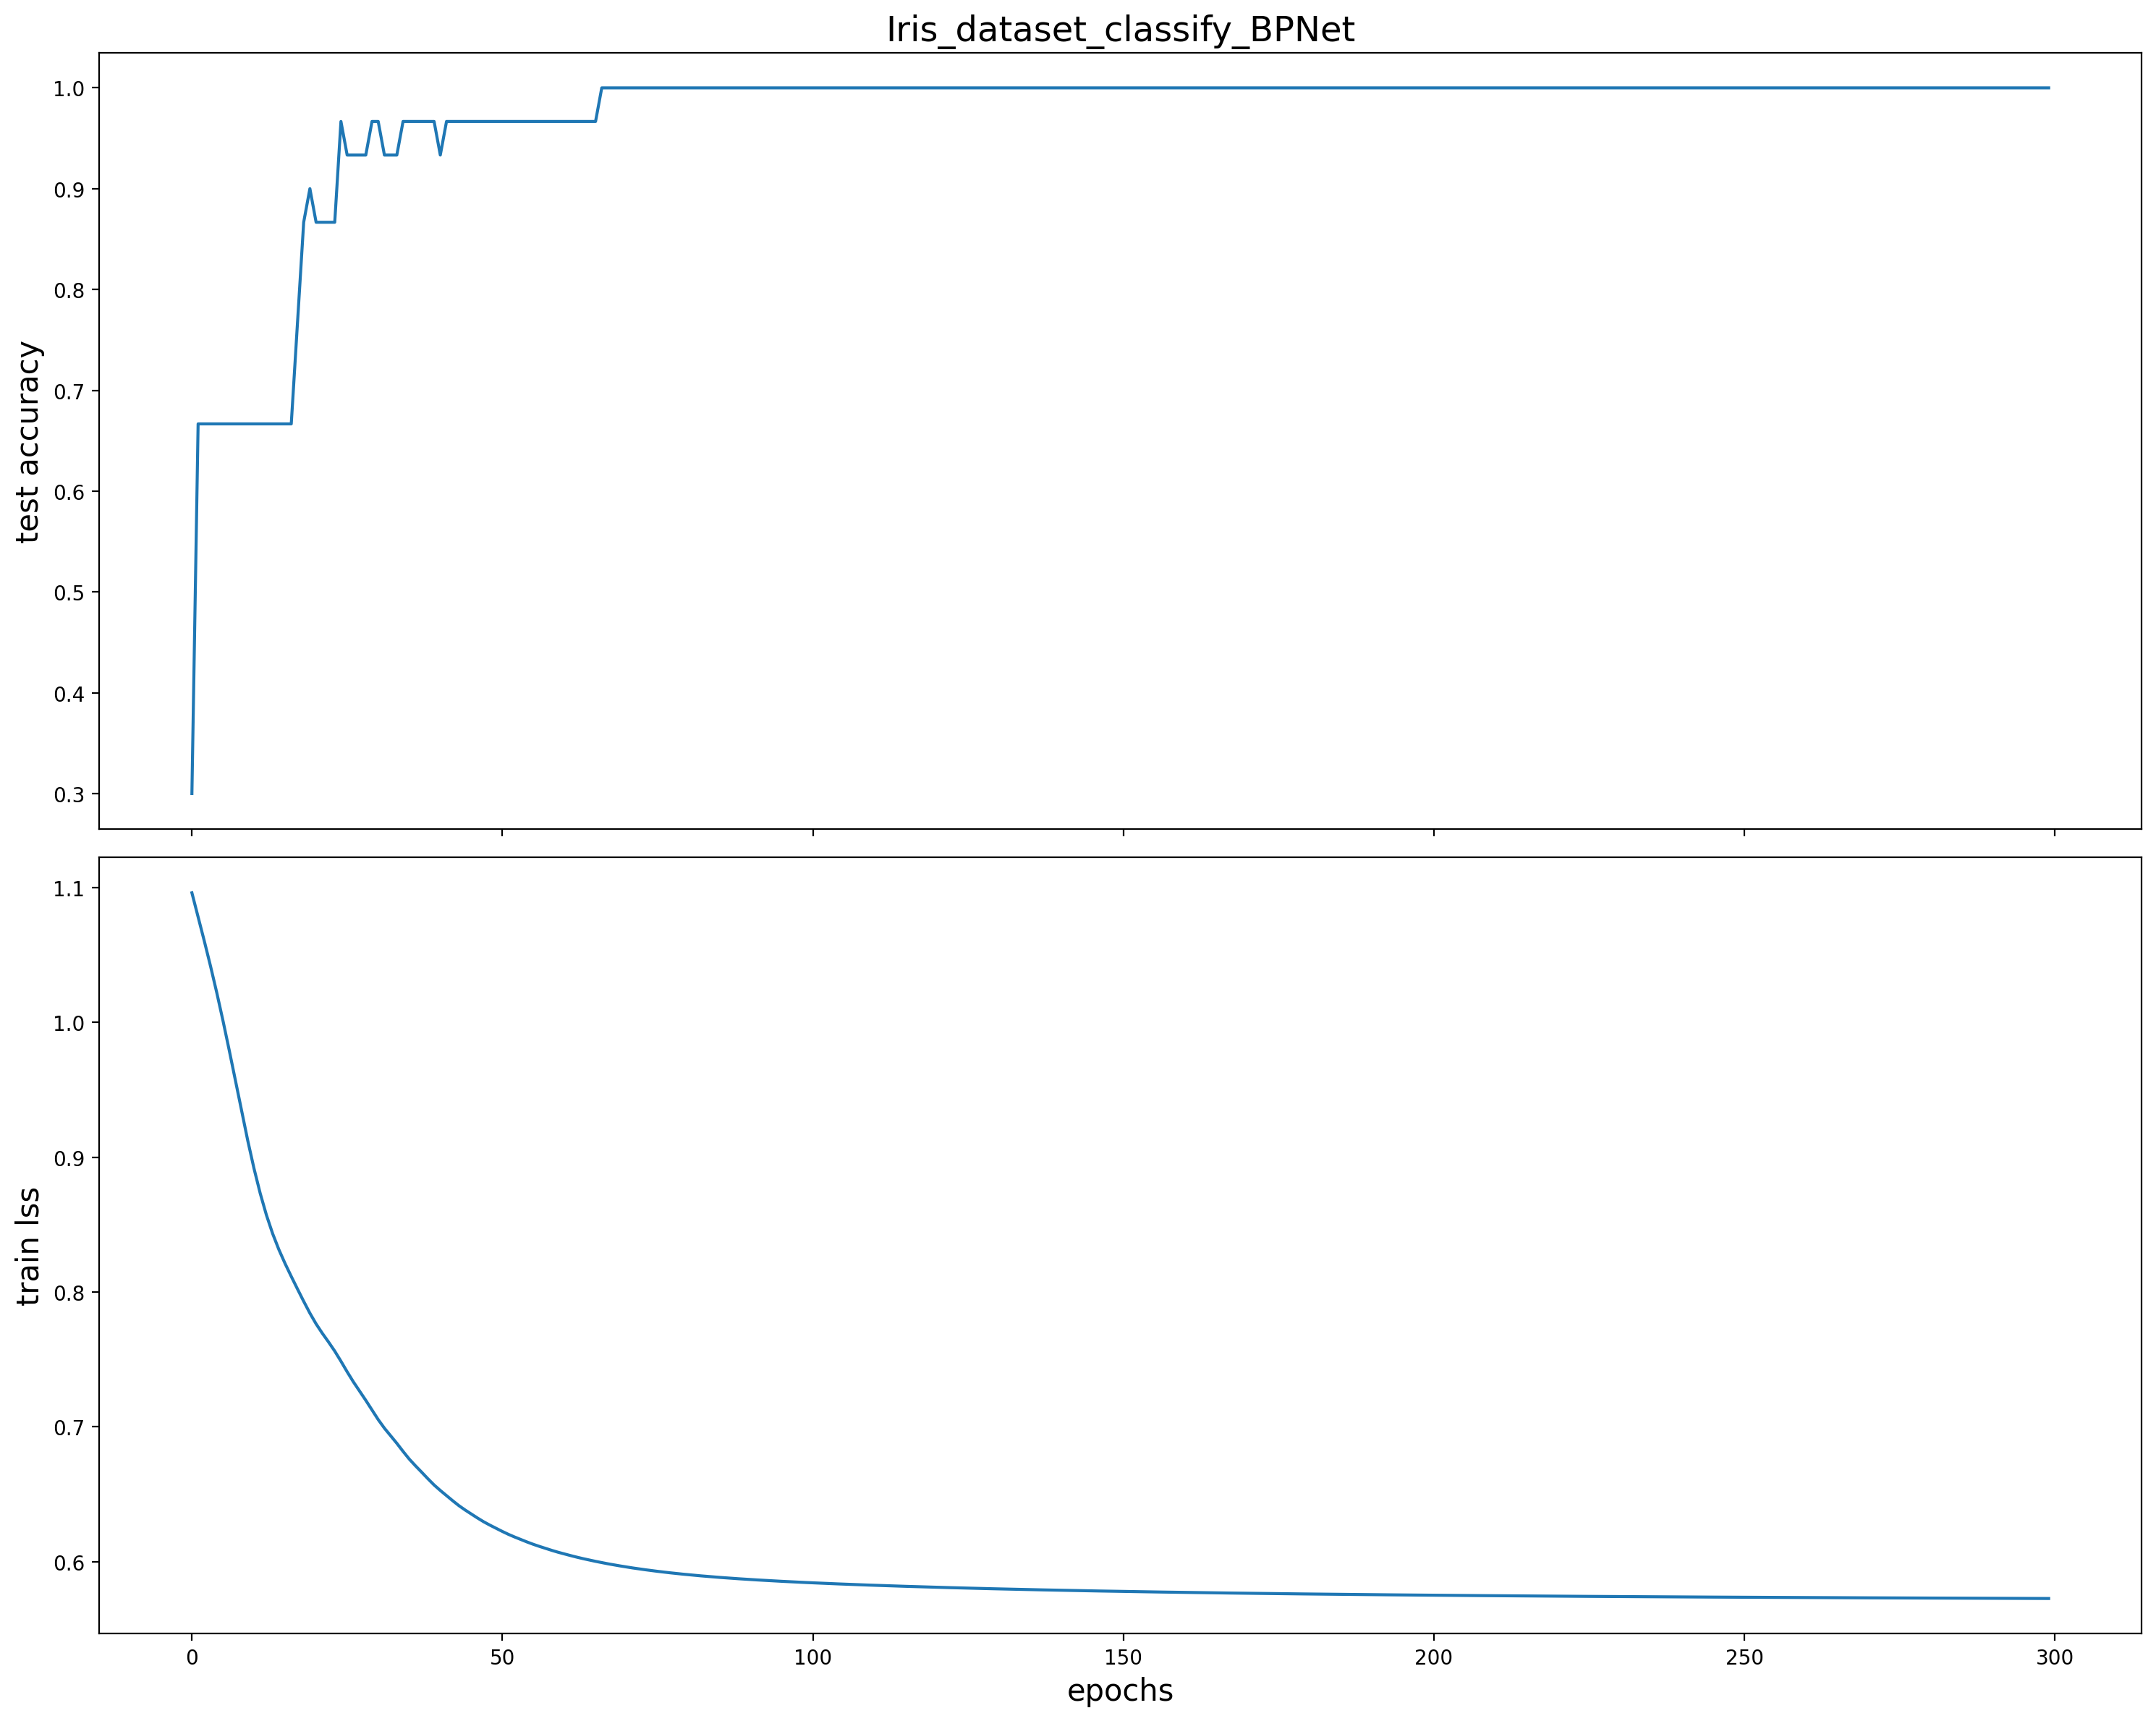

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #训练集，测试集划分函数
import torch
import torch.nn.functional as Fun

#设置超参数
lr=0.02 #学习率
epochs=300 #训练轮数
n_feature=4 #输入特征
n_hidden=20 #隐层节点数
n_output=3 #输出(鸢尾花三种类别)

#1.准备数据
iris=datasets.load_iris() #下载数据集

#设置训练集数据80%，测试集20%
x_train0,x_test0,y_train,y_test=train_test_split(iris.data,iris.target,test_size=0.2,random_state=22)
#归一化(也就是所说的min-max标准化)通过调用sklearn库的标准化函数
min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train0)
x_test = min_max_scaler.fit_transform(x_test0)

#将数据类型转换为tensor方便pytorch使用
x_train=torch.FloatTensor(x_train)
y_train=torch.LongTensor(y_train)
x_test=torch.FloatTensor(x_test)
y_test=torch.LongTensor(y_test)

#2.定义BP神经网络
class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden=torch.nn.Linear(n_feature,n_hidden)#定义隐层网络
        self.out=torch.nn.Linear(n_hidden,n_output)#定义输出层网络
    def forward(self,x):
        x=Fun.relu(self.hiddden(x)) #隐层激活函数采用relu()函数
        out=Fun.softmax(self.out(x),dim=1) #输出层采用softmax函数
        return out
#3.定义优化器和损失函数
net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #调用网络
optimizer=torch.optim.Adam(net.parameters(),lr=lr) #使用Adam优化器，并设置学习率
loss_fun=torch.nn.CrossEntropyLoss() #对于多分类一般使用交叉熵损失函数

#4.训练数据
loss_steps=np.zeros(epochs) #构造一个array([ 0., 0., 0., 0., 0.])里面有epochs个0
accuracy_steps=np.zeros(epochs)

for epoch in range(epochs):
    y_pred=net(x_train) #前向传播
    print(x_train.shape)
    print(y_pred.shape)
    print(y_train.shape)
    loss=loss_fun(y_pred,y_train)#预测值和真实值对比
    optimizer.zero_grad() #梯度清零
    loss.backward() #反向传播
    optimizer.step() #更新梯度
    loss_steps[epoch]=loss.item()#保存loss
    running_loss = loss.item()
    print(f"第{epoch}次训练，loss={running_loss}".format(epoch,running_loss))
    with torch.no_grad(): #下面是没有梯度的计算,主要是测试集使用，不需要再计算梯度了
        y_pred=net(x_test)
        correct=(torch.argmax(y_pred,dim=1)==y_test).type(torch.FloatTensor)
        accuracy_steps[epoch]=correct.mean()
        print("测试鸢尾花的预测准确率", accuracy_steps[epoch])

#print("测试鸢尾花的预测准确率",accuracy_steps[-1])

#5.绘制损失函数和精度
fig_name="Iris_dataset_classify_BPNet"
fontsize=15
fig,(ax1,ax2)=plt.subplots(2,figsize=(15,12),sharex=True)
ax1.plot(accuracy_steps)
ax1.set_ylabel("test accuracy",fontsize=fontsize)
ax1.set_title(fig_name,fontsize="xx-large")
ax2.plot(loss_steps)
ax2.set_ylabel("train lss",fontsize=fontsize)
ax2.set_xlabel("epochs",fontsize=fontsize)
plt.tight_layout()
plt.savefig(fig_name+'.png')
plt.show()